# GCP Study

## Phase 1. Getting the Analytical Results

### Setup Steps

After GCP account was established, GCP Storage bucket `batanov` was created. JSON file downloaded from https://coinmarketcap.com/api/ was converted to CSV using an online converter tool https://json-csv.com/ and the resulting file was placed in the bucket.

Downloaded CoinMarketCap file was made publically accessible using GCP web console. It is located at https://storage.googleapis.com/batanov/crypto.csv.

The bucket itself was made accessible to authenticated Google users with `gsutil defacl ch -u allUsers:R gs://batanov`.

Next, CSV file was imported into BigQuery using Create Table wizard. The queries were initially executed using BugQuery web interface.

Then, Datalab notebook was ran locally with `datalab create --verbosity=debug datalab-caserta` and ran using `datalab connect --verbosity=debug datalab-caserta`  

The queries were executed programmatically from this notebook.

The setup was verified by running the following query.

In [2]:
%%bq query
SELECT count(*)
FROM `starry-sunup-200204.crypto.test`

f0_
100


### How many coins have a USD price greater than $6000?

The value was changed to 6000 from the original 8000.

In [5]:
%%bq query
SELECT count(*)
FROM `starry-sunup-200204.crypto.test`
WHERE price_usd > 6000

f0_
1


And it is the Bitcoin

In [6]:
%%bq query
SELECT *
FROM `starry-sunup-200204.crypto.test`
WHERE price_usd > 6000

_id_,name,symbol,rank,price_usd,price_btc,_24h_volume_usd,market_cap_usd,available_supply,total_supply,max_supply,percent_change_1h,percent_change_24h,percent_change_7d,last_updated
bitcoin,Bitcoin,BTC,1,6821.87,1.0,5065050000.0,115689535129.0,16958625.0,16958625.0,21000000.0,0.39,-7.41,-12.12,1522904667


### What is the total market cap of the top 100 cryptocurrencies (in USD)?

In [7]:
%%bq query
SELECT sum(market_cap_usd)
FROM `starry-sunup-200204.crypto.test`

f0_
245889965934.0


### Which coins have an available supply less than $5M?

In [8]:
%%bq query
SELECT *
FROM `starry-sunup-200204.crypto.test`
WHERE available_supply < 5000000

_id_,name,symbol,rank,price_usd,price_btc,_24h_volume_usd,market_cap_usd,available_supply,total_supply,max_supply,percent_change_1h,percent_change_24h,percent_change_7d,last_updated
digixdao,DigixDAO,DGD,31,203.037,0.029952,13305800.0,406074000.0,2000000.0,2000000.0,,1.22,-11.67,-28.62,1522904646
zcash,Zcash,ZEC,26,183.382,0.0270525,36532600.0,666143138.0,3632544.0,3632544.0,,0.54,-7.87,-10.13,1522904647
byteball,Byteball Bytes,GBYTE,86,168.892,0.024915,139508.0,108972843.0,645222.0,1000000.0,,1.56,-9.66,-10.2,1522904648
maker,Maker,MKR,42,492.087,0.0725927,46436.9,304221849.0,618228.0,1000000.0,,-0.34,-5.64,-14.02,1522904649
veritaseum,Veritaseum,VERI,56,104.044,0.0153485,581217.0,211900738.0,2036645.0,100000000.0,,1.72,-14.8,-25.45,1522904650
zcoin,ZCoin,XZC,77,27.7614,0.00409537,12386200.0,123848435.0,4461174.0,4461174.0,21400000.0,-0.2,-9.72,-13.7,1522904648


### Which 5 coins have seen the greatest percentage growth in the last week?

In [10]:
%%bq query
SELECT *
FROM `starry-sunup-200204.crypto.test`
ORDER BY percent_change_7d desc
LIMIT 5

_id_,name,symbol,rank,price_usd,price_btc,_24h_volume_usd,market_cap_usd,available_supply,total_supply,max_supply,percent_change_1h,percent_change_24h,percent_change_7d,last_updated
verge,Verge,XVG,22,0.0561223,8.28e-06,145545000.0,831541915.0,14816604365.0,14816604365.0,16555000000.0,-0.11,-15.61,40.28,1522904643
vertcoin,Vertcoin,VTC,90,2.32519,0.00034301,20182800.0,101477686.0,43642750.0,43642750.0,84000000.0,-3.14,14.96,19.82,1522904641
ontology,Ontology,ONT,27,2.44807,0.00036114,41526400.0,590563719.0,241236451.0,1000000000.0,,2.4,3.25,12.09,1522904661
ardor,Ardor,ARDR,46,0.279858,4.128e-05,26723400.0,279578001.0,998999495.0,998999495.0,998999495.0,-0.55,-16.29,11.85,1522904647
binance-coin,Binance Coin,BNB,16,12.4669,0.00183912,104959000.0,1449421792.0,116261604.0,197192382.0,,0.35,-2.62,9.65,1522904652


### How many ticker symbols contain the letter "X" ?

In [21]:
%%bq query
SELECT *
FROM `starry-sunup-200204.crypto.test`
WHERE symbol LIKE '%X%'

_id_,name,symbol,rank,price_usd,price_btc,_24h_volume_usd,market_cap_usd,available_supply,total_supply,max_supply,percent_change_1h,percent_change_24h,percent_change_7d,last_updated
stellar,Stellar,XLM,8,0.203224,2.998e-05,53641400.0,3769993550.0,18550926812.0,103827633055.0,,0.39,-12.0,-3.46,1522904643
monero,Monero,XMR,11,169.583,0.0250169,39622500.0,2696360967.0,15899949.0,15899949.0,,0.26,-8.97,-12.06,1522904644
nem,NEM,XEM,15,0.228305,3.368e-05,46417100.0,2054745000.0,8999999999.0,8999999999.0,,0.57,-8.59,-7.06,1522904644
pivx,PIVX,PIVX,53,3.93694,0.00058078,6798110.0,220117420.0,55910789.0,55910789.0,,1.24,-4.29,-10.37,1522904646
0x,0x,ZRX,48,0.518692,7.652e-05,4947460.0,270711252.0,521911369.0,1000000000.0,,0.35,-10.0,-15.33,1522904652
tron,TRON,TRX,14,0.0318578,4.7e-06,189430000.0,2094592766.0,65748192475.0,100000000000.0,,5.02,-5.33,-32.37,1522904653
icon,ICON,ICX,23,2.03111,0.00029963,34901500.0,786125909.0,387042508.0,400230000.0,,0.49,-8.38,-25.28,1522904655
zcoin,ZCoin,XZC,77,27.7614,0.00409537,12386200.0,123848435.0,4461174.0,4461174.0,21400000.0,-0.2,-9.72,-13.7,1522904648
gxchain,GXChain,GXS,67,2.56181,0.00037792,1059400.0,153708600.0,60000000.0,100000000.0,100000000.0,0.21,-5.92,-6.15,1522904651
cryptonex,Cryptonex,CNX,55,4.73638,0.00069871,1187290.0,214069915.0,45196947.0,106634573.0,210000000.0,1.14,-6.85,-7.64,1522904654


### BigQuery Python API

The dataset above can be used in Python using BigQuery API

In [6]:
import google.datalab.bigquery as bq

In [10]:
q1 = bq.Query('SELECT * FROM `starry-sunup-200204.crypto.test` WHERE price_usd > 6000')
output_options = bq.QueryOutput.table(use_cache=False)
result = q1.execute(output_options=output_options).result()
print(list(result))

[{'rank': 1, 'percent_change_7d': -12.12, 'max_supply': '21000000.0', '_id_': 'bitcoin', 'available_supply': 16958625.0, '_24h_volume_usd': 5065050000.0, 'market_cap_usd': 115689535129.0, 'price_btc': 1.0, 'price_usd': 6821.87, 'last_updated': 1522904667, 'total_supply': 16958625.0, 'symbol': 'BTC', 'percent_change_1h': 0.39, 'percent_change_24h': -7.41, 'name': 'Bitcoin'}]


In [18]:
#convert to Pandas dataframe
df1 = result.to_dataframe()
type(df1)

pandas.core.frame.DataFrame

In [19]:
df1

,_id_,name,symbol,rank,price_usd,price_btc,_24h_volume_usd,market_cap_usd,available_supply,total_supply,max_supply,percent_change_1h,percent_change_24h,percent_change_7d,last_updated
0,bitcoin,Bitcoin,BTC,1,6821.87,1.0,5.065050e+09,1.156895e+11,16958625.0,16958625.0,21000000.0,0.39,-7.41,-12.12,1522904667


### Data Visualization

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [24]:
q2 = bq.Query('SELECT symbol, percent_change_7d FROM `starry-sunup-200204.crypto.test` ORDER BY percent_change_7d desc LIMIT 5')
output_options = bq.QueryOutput.table(use_cache=False)
result = q2.execute(output_options=output_options).result()
df2 = result.to_dataframe()

In [25]:
df2

,symbol,percent_change_7d
0,XVG,40.28
1,VTC,19.82
2,ONT,12.09
3,ARDR,11.85
4,BNB,9.65


In [26]:
%matplotlib inline

In [42]:
mpl.rcParams['font.family'] = 'DejaVu Sans'

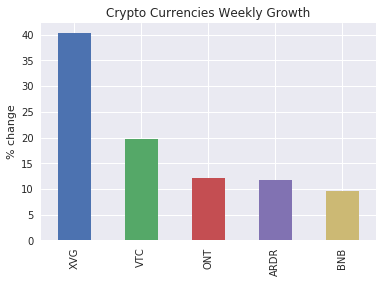

In [43]:
df2['percent_change_7d'].plot(kind='bar')
plt.title('Crypto Currencies Weekly Growth')
plt.ylabel('% change')
plt.xticks(np.arange(5), df2['symbol'])
plt.show()

## Phase 2: Building Data Ingestion Pipeline

After analytical results were obtained, automation was added to the project by building a data pipeline to upload data from the web API into BigQuery programmatically.

First, csv file was produced and stored inside the Docker container running on the Datalab VM in the GCP.

In [1]:
import urllib.request
import json
import csv
with urllib.request.urlopen("https://api.coinmarketcap.com/v1/ticker/") as url:
    data = json.loads(url.read().decode())
    #print(data[0:2])

with open('CoinMarketCap.csv', 'w') as fileout:
    csvwriter = csv.writer(fileout)
    header = data[0].keys()
    csvwriter.writerow(header)
    for e in data: csvwriter.writerow(e.values())

In [2]:
%pwd

'/content/datalab/notebooks'

Then, csv file was moved to Google Cloud storage bucket that was previously created.

The file can be moved manually:

a) open google cloud shell from the GCP web console  
b) open docker `shell: docker exec -it datalab /bin/bash`  
c) run gsutil cp from docker shell: `gsutil cp /content/datalab/notebooks/CoinMarketCap.csv gs://batanov`

Initial attempts to move it programmatically did not yeild results. Tried to:

Move file (https://stackoverflow.com/questions/37003862/google-cloud-storage-how-to-upload-a-file-from-python-3)  
`from gcloud import storage`  
`from oauth2client.service_account import ServiceAccountCredentials`  

Write file (https://cloud.google.com/appengine/docs/standard/python/googlecloudstorageclient/read-write-to-cloud-storage)  
`import cloudstorage as gcs`

Move file (http://oswco.com/2016/mar/31/few-hints-google-cloud-datalab/)  
`import gcp`  

Python.org recipe did work (https://pypi.python.org/pypi/google-cloud-storage)

In [3]:
from google.cloud import storage

In [4]:
client = storage.Client()
bucket = client.get_bucket('batanov')
blob2 = bucket.blob('CoinMarketCap.csv')
blob2.upload_from_filename(filename='/content/datalab/notebooks/CoinMarketCap.csv')

Finally, csv file was loaded up to BigQuery (used separate schema and table names not to disrupt the results from Phase 1)

Used instructions from https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv  
and from https://cloud.google.com/resource-manager/reference/rest/v1/projects/setIamPolicy

Using BigQuery web console created dataset 'CoinMarketCap'  
Using IAM web console updated access policy and added 'Compute Engine default service account' to 'BigQuery Data Owner' role

In [5]:
from google.cloud import bigquery

In [7]:
client = bigquery.Client()
dataset_id = 'CoinMarketCap'
dataset_ref = client.dataset(dataset_id)
job_config = bigquery.LoadJobConfig()
job_config.schema = [
  bigquery.SchemaField('price_btc', 'STRING'),  
  bigquery.SchemaField('price_usd', 'STRING'),  
  bigquery.SchemaField('last_updated', 'STRING'),
  bigquery.SchemaField('_24h_volume_usd', 'STRING'),
  bigquery.SchemaField('market_cap_usd', 'STRING'),
  bigquery.SchemaField('symbol', 'STRING'),
  bigquery.SchemaField('id', 'STRING'),
  bigquery.SchemaField('total_supply', 'STRING'),
  bigquery.SchemaField('rank', 'STRING'),
  bigquery.SchemaField('max_supply', 'STRING'),
  bigquery.SchemaField('percent_change_1h', 'STRING'),
  bigquery.SchemaField('percent_change_7d', 'STRING'), 
  bigquery.SchemaField('name', 'STRING'),
  bigquery.SchemaField('available_supply', 'STRING'),
  bigquery.SchemaField('percent_change_24h', 'STRING'),
]
job_config.skip_leading_rows = 1

load_job = client.load_table_from_uri(
  'gs://batanov/CoinMarketCap.csv',
  dataset_ref.table('CoinMarketCap'),
  job_config=job_config)

assert load_job.job_type == 'load'

load_job.result()  # Waits for table load to complete.

assert load_job.state == 'DONE'
assert client.get_table(dataset_ref.table('CoinMarketCap')).num_rows == 100

Note that if the above code is executed multiple times, each time the set of 100 rows will be added to the table

Let's verify that we can query the data

In [8]:
%%bq query 
SELECT symbol, percent_change_7d
FROM `starry-sunup-200204.crypto.test`
ORDER BY percent_change_7d desc
LIMIT 5

symbol,percent_change_7d
XVG,40.28
VTC,19.82
ONT,12.09
ARDR,11.85
BNB,9.65


And finally let's visualize the data using native Datalab capabilities (as opposed to Pandas and matplotlib)

Name the query and use %chart command

In [9]:
%%bq query --name q1
SELECT symbol, percent_change_7d
FROM `starry-sunup-200204.crypto.test`
ORDER BY percent_change_7d desc
LIMIT 5

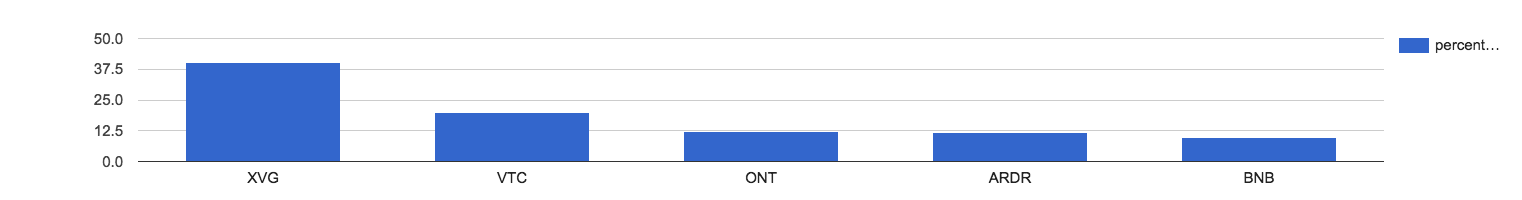

In [10]:
%chart columns --data q1 --fields symbol,percent_change_7d

In [11]:
%%chart --help

usage: %%chart [-h]
               {annotation,area,bars,bubbles,calendar,candlestick,columns,combo,gauge,geo,heatmap,histogram,line,map,org,paged_table,pie,sankey,scatter,stepped_area,table,timeline,treemap}
               ...

Generate an inline chart using Google Charts using the data in a Table, Query,
dataframe, or list. Numerous types of charts are supported. Options for the
charts can be specified in the cell body using YAML or JSON.

positional arguments:
  {annotation,area,bars,bubbles,calendar,candlestick,columns,combo,gauge,geo,heatmap,histogram,line,map,org,paged_table,pie,sankey,scatter,stepped_area,table,timeline,treemap}
                        commands
    annotation          Generate a annotation chart.
    area                Generate a area chart.
    bars                Generate a bars chart.
    bubbles             Generate a bubbles chart.
    calendar            Generate a calendar chart.
    candlestick         Generate a candlestick chart.
    columns          